# Capstone Project: Stroke Risk Prediction - Exploratory Data Analysis #
This is a capstone project for Springboard's data science intensive track. The dataset used in this project is sourced from the data science competition sponsor by McKinsey analytics and held in a platform "Analytics Vidhya". 
The competition link can be found here [contest page] (https://datahack.analyticsvidhya.com/contest/mckinsey-analytics-online-hackathon/).

**Problem Statement:** a chain of hospitals in US collected anonymized pool of patients data for stroke classification. Stroke is one of critical disease which affects nearly 1 in 20 Americans and is a disease that affects arteries leading to and within the brain. A stroke occurs when a blood vessel that carries oxygen and nutrients to the brain is either blocked by a clot or ruptures. When that happens part of the brain cannot get the blood (and oxygen) it needs, so the brain cells in the affected region is dead. The clients captured several lifestyle, health monitoring measurements and demographic factors about their anonymized patients. These include features like age, gender, health monitoring measurements (i.e., glucose level, body mass index) and lifestyle factors (i.e., smoking status, occupation type etc.). 

**Stakeholders:**
Hospital cardiac unit managers, a group of clinicians, insurance companies and employers from patient population.

## Part A. Import Cleaned Dataset ##

In [1]:
# Import all libraries #
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import csv
from sklearn.utils import shuffle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Authorization #
__author__ = "Taesun Yoo"
__email__ = "yoots1988@gmail.com"

In [2]:
#################################
# Part 2 - Discover the Problem #
#################################
# --- 1. Write Out List of Functions --- #
def load_file(file):
    '''load input CSVs as a dataframe'''
    return pd.read_csv(file, encoding='latin1')


def convert_dt_as_date(df, var_name, date_format):
    '''convert the variable as specified date format'''
    df[var_name] = pd.to_datetime(df[var_name], format=date_format)
    return df[var_name]


def convert_dt_as_custom(df, var_name, dt_type):
    '''convert datatype on selected variables'''
    df[var_name] = df[var_name].astype(dt_type)
    return df[var_name]


def convert_dt_to_cat(df):
    '''convert data type to category'''
    for col in df.columns:
        if df[col].dtype.name == 'object':
            df[col] = df[col].astype('category')


def eda_encode_cat_var(df, col, num_var):
    '''encode the cat. variables by mean of a num. variable by each cat'''
    cat_dict={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = df[df[col] == cat][num_var].mean()
    df[col] = df[col].map(cat_dict)
    

def feature_replacement(X):
    ''' replace missing values based on specific data type of a column '''
    for col in X.columns:
        if X[col].dtype.name == 'object':
            mode = X[col].mode().iloc[0]
            X[col] = X[col].fillna(mode)
        elif X[col].dtype.name == 'float64':
            mean = X[col].mean()
            X[col] = X[col].fillna(mean)
        else:
            X[col].dtype.name == 'int64'
            median = X[col].median()
            X[col] = X[col].fillna(median)
            

def eda_missing(df):
    '''compute missing % on each var'''
    df_missing = pd.DataFrame(df.isnull().sum(), columns=['count'])
    df_missing['pct'] = (df_missing['count']/len(df)) * 100
    return df_missing


def eda_stat_num(df):
    ''' perform eda for numerical features '''
    df_stat_num = df.describe().T
    df_stat_num = df_stat_num[['count', 'min', 'mean', 'max', 'std', '25%', '50%', '75%']]
    df_stat_num = pd.DataFrame(df_stat_num)
    return df_stat_num


def eda_stat_cat(df):
    ''' perform eda for categorical features '''
    df_stat_cat = df.describe(include='category').T
    df_stat_cat = pd.DataFrame(df_stat_cat)
    return df_stat_cat


def eda_outliers(df):
    '''check outliers using the IQR method'''
    df['IQR'] = df['75%'] - df['25%']
    df['LB']  = df['25%'] - 1.5*df['IQR']
    df['UB']  = df['75%'] + 1.5*df['IQR']
    df = df.drop(['count','std','mean','25%','50%','75%','IQR'], axis=1)
    return df


def eda_agg_df_var(df, cat_var, kpi_dict):
    '''compute aggregated dataframe to calculate the KPIs'''
    df_agg = df.groupby(by=cat_var).agg(kpi_dict)
    return df_agg


def eda_grouped_df_var(df, cat_var):
    '''create a grouped dataframe by categorical variable'''
    df_grp = pd.DataFrame(df.groupby([cat_var])[cat_var].count())
    df_grp.columns = ['count']
    return df_grp


def plot_hist(df, var_1):
    '''plot a histogram'''
    plt.figure()
    print("skenewss is:", df[var_1].skew())
    df[var_1].hist(color='green')
    plt.title('Histogram of ' + var_1)
    plt.xlabel(var_1)
    plt.ylabel('patients')
    plt.show()


def plot_bar_chart(df, var_name_1):
    '''plot a bar chart'''
    plt.figure()
    var_count_1 = df[var_name_1].value_counts()
    sns.barplot(var_count_1.index,  var_count_1.values, alpha=0.9)
    plt.title('Frequency chart of ' + var_name_1)
    plt.ylabel('patients')
    plt.xlabel(var_name_1)
    plt.show()

    
def plot_freq_chart(x,y,df,order):
    '''plot a frequency chart'''
    plt.figure(figsize=(8,8))
    sns.countplot(x=x, hue=y, data=df, order=order)
    plt.title('Bar chart: ' + x + ' of patient group labels', fontsize=20)
    plt.xticks(rotation=270, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(x, fontsize=12)
    plt.ylabel('patients', fontsize=12)
    plt.legend(loc='upper right', fontsize=20)
    plt.show()


def plot_pie_chart(df_1, var_name_1,
                   df_2, var_name_2):
    '''plot a pie chart of specified variables'''
    plt.figure(figsize=(15,15))
    # Sub-plot 1:
    plt.subplot(1,2,1)
    plt.pie(df_1, autopct='%.0f%%', wedgeprops={'edgecolor':'white'},
            textprops={'fontsize':15})
    plt.title('Pie Chart of '+ var_name_1)
    plt.legend(labels = df_1.index, loc='upper right')
    # Sub-plot 2:
    plt.subplot(1,2,2)
    plt.pie(df_2, autopct='%.0f%%', wedgeprops={'edgecolor':'white'},
            textprops={'fontsize':15})
    plt.title('Pie Chart of '+ var_name_2)
    plt.legend(labels = df_2.index, loc='upper right')
    plt.show()
    

def plot_box(df, num_var_1, cat_var_1,
             num_var_2, cat_var_2, hue=None):
    '''plot a box-whisker of specified variables'''
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    # Sub-plot 1:
    plt.subplot(1,2,1)
    df.sort_values(by=[num_var_1], inplace=True)
    sns.set(style='whitegrid')
    sns.boxplot(cat_var_1, num_var_1, hue, df)
    plt.title('Box plot of ' + num_var_1 + ' by ' + cat_var_1)
    plt.xticks(rotation=270, fontsize=10)
    # Sub-plot 2:
    plt.subplot(1,2,2)
    df.sort_values(by=[num_var_2], inplace=True)
    sns.set(style='whitegrid')
    sns.boxplot(cat_var_2, num_var_2, hue, df)
    plt.title('Box plot of ' + num_var_2 + ' by ' + cat_var_2)
    plt.xticks(rotation=270, fontsize=10)
    

def plot_crosstab(df, cat_var_1, cat_var_2):
    '''plot a crosstab of two categorical variables'''
    table = pd.crosstab(df[cat_var_1], df[cat_var_2])
    return table


def plot_corr_matrix(df, list_vars):
    ''' plot a correlation matrix '''
    corr = df[list_vars].corr()
    # Create a mask
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(corr)] = True
    plt.figure(figsize=(12,12))
    sns.heatmap(corr, cmap=sns.diverging_palette(220,10,as_cmap=True),
                annot=True, annot_kws={'size':15}, fmt=".2f", mask=mask)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()


def plot_scatter(df, var_1, var_2, color, factor=None):
    '''Scatter plot of two continuous numeric features'''
    plt.figure(figsize=(8,8))
    plt.scatter(df[var_1], df[var_2], color=color)
    plt.title('Relationship between '+ var_1 + ' and ' + var_2)
    plt.xlabel(var_1)
    plt.ylabel(var_2)
    plt.show()

    
def compute_pearson_r(df, var_x, var_y):
    '''compute Pearson r correlation'''
    corr_mat = np.corrcoef(df[var_x],df[var_y])
    return corr_mat[0, 1]


def plot_linear_reg(df, var_x, var_y, 
                    pearson_r, color, label):
    '''plot a pair of linear regressions'''
    plt.figure(figsize=(10,10))
    plt.plot(df[var_x], df[var_y], 'r--', label='pearson_r =%.2f' % pearson_r,
             marker='.', linestyle='none', color=color)
    plt.margins(0.02)
    plt.legend(loc='upper left')
    plt.xlabel(var_x)
    plt.ylabel(var_y)
    plt.title(var_x + ' vs. ' + var_y + ' by ' + label)
    # Fit linear regression:
    a,b = np.polyfit(df[var_x], df[var_y], 1)
    x = np.array([0, 84])
    y = a*x + b
    plt.plot(x,y)

In [3]:
# --- 2. Load the data --- #
# define input CSVs:
if __name__ == '__main__':
    eda_file = 'stroke_train.csv'

# load data:
df_eda = load_file(eda_file)

# check data types:
df_eda.info()

# define variable list:
cat_vars = list(df_eda.select_dtypes(include='object').columns)
num_vars = list(df_eda.select_dtypes(include='float64').columns)
label_var = 'stroke'
id_var = 'id'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


## Part B. Exploratory Data Analysis ##

**Stroke Patients Data: training set** 

Data exploration is conducted on a cleaned training set. The main goal of this phase is to explore any interesting relationships among features and identify which features are good predictors on stroke label predictions.

Following set of questions are asked:

1. Can I count something interesting?
2. Can I find some trends (increase or decrease and any anomalies)?
3. Can I plot a bar chart or a histogram?
4. Can I make a scatter plot?

These set of guiding questions will help us to explore any insights and tell a compelling story about the Stroke patients dataset.

In [4]:
# compute top 10 rows:
df_eda.head(10)

# check duplicates:
df_eda.duplicated().sum()

0

In [5]:
# create a missing % dataframe:
df_missing_pre = eda_missing(df_eda)
df_missing_pre

,count,pct
id,0,0.000000
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000
avg_glucose_level,0,0.000000
bmi,1462,3.368664


In [6]:
# compute feature impuation by data types:
feature_replacement(df_eda)

In [7]:
# create a missing % dataframe:
df_missing_post = eda_missing(df_eda)
df_missing_post

,count,pct
id,0,0.0
gender,0,0.0
age,0,0.0
hypertension,0,0.0
heart_disease,0,0.0
ever_married,0,0.0
work_type,0,0.0
Residence_type,0,0.0
avg_glucose_level,0,0.0
bmi,0,0.0


In [8]:
# convert data type: object to category
convert_dt_to_cat(df_eda)

In [9]:
# ---3 perform summary statistics ---
# numerical features:
df_stat_num = eda_stat_num(df_eda[num_vars])
df_stat_num

,count,min,mean,max,std,25%,50%,75%
age,43400.0,0.08,42.217894,82.00,22.519649,24.00,44.00,60.00
avg_glucose_level,43400.0,55.00,104.482750,291.05,43.111751,77.54,91.58,112.07
bmi,43400.0,10.10,28.605038,97.60,7.638023,23.40,28.10,32.60


In [10]:
# categorical features:
df_stat_cat = eda_stat_cat(df_eda)
df_stat_cat

,count,unique,top,freq
gender,43400,3,Female,25665
ever_married,43400,2,Yes,27938
work_type,43400,5,Private,24834
Residence_type,43400,2,Urban,21756
smoking_status,43400,3,never smoked,29345


In [11]:
# ---4 detect outliers ---
# create a dataframe for IQR:
df_outliers = eda_outliers(df_stat_num)
df_outliers

# check outliers:
# lower bounds (LBs)
df_eda[df_eda.avg_glucose_level < 25.745]

# upper bounds (UBs)
df_eda[df_eda.avg_glucose_level > 163.8649]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5,32257,Female,47.0,0,0,Yes,Private,Urban,210.95,50.100000,never smoked,0
7,41413,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.000000,never smoked,0
9,28674,Female,74.0,1,0,Yes,Self-employed,Urban,205.84,54.600000,never smoked,0
23,4057,Male,71.0,0,0,Yes,Private,Urban,198.21,27.300000,formerly smoked,0
28,36275,Female,54.0,0,0,Yes,Private,Rural,206.72,26.700000,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43381,57176,Male,45.0,0,0,Yes,Private,Urban,214.05,40.500000,formerly smoked,0
43384,44814,Female,65.0,0,0,Yes,Private,Rural,200.92,30.700000,formerly smoked,0
43388,31321,Female,64.0,1,0,Yes,Govt_job,Rural,228.43,28.605038,smokes,0
43390,10096,Female,69.0,0,0,Yes,Self-employed,Urban,229.85,31.200000,never smoked,0


In [12]:
# ---5 aggregate dataframe and compute KPIs ---
# Define the dictionary for KPIs:
kpi_dict = {'id':'nunique', 'age':'mean',
            'avg_glucose_level':'mean', 'bmi':'mean'}

df_agg_stroke = eda_agg_df_var(df_eda, 'stroke', kpi_dict)

# Print a summary KPI table by Worker Region:
df_agg_stroke

,id,age,avg_glucose_level,bmi
stroke,,,,
0,42617,41.741565,104.021590,28.585981
1,783,68.143448,129.582669,29.642280


### Summary: Age, avg_glucose_level, bmi

Visualizes the numerical variables. First, the box plot shows that mean of age is somewhere around 45. Second, the histogram shows the distribution of age is a multi-modal skewed distribution (i.e., multiple peaks on a distribution curve).

skenewss is: -0.10249737146133675


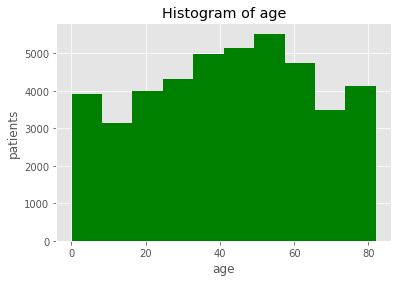

skenewss is: 0.9142582269108889


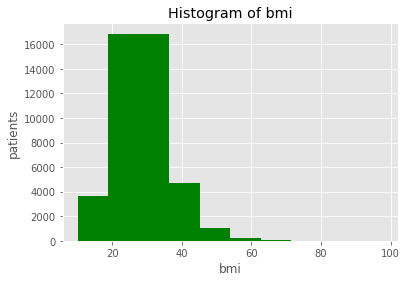

skenewss is: 1.6754049014377763


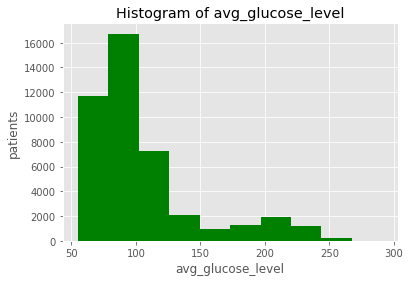

In [13]:
# ---6 visualize data: uni-variate ---
# plot a histogram:    
plot_hist(df_eda, 'age')

plot_hist(df_eda, 'bmi')

plot_hist(df_eda, 'avg_glucose_level')

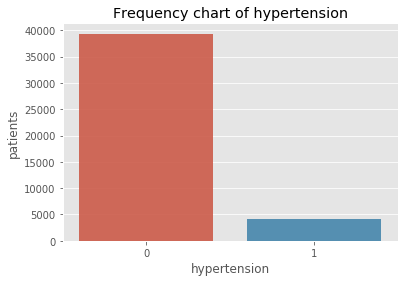

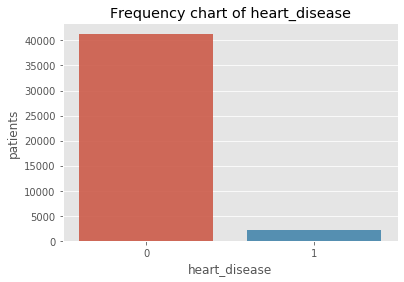

In [14]:
# plot a bar chart:
plot_bar_chart(df_eda, 'hypertension')

plot_bar_chart(df_eda, 'heart_disease')

C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


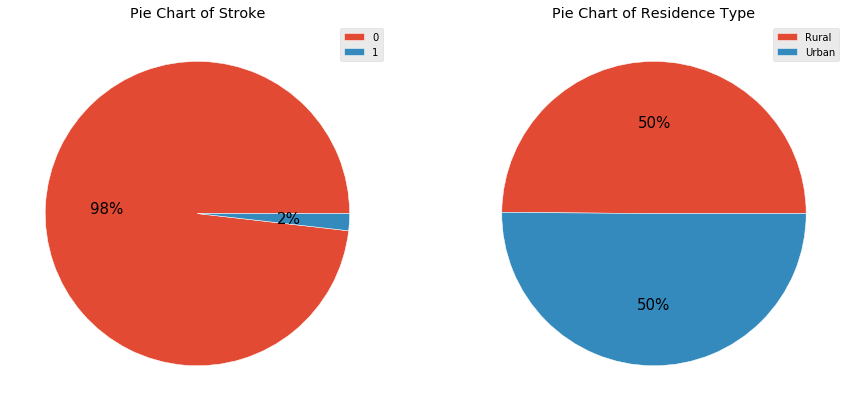

In [15]:
# grouped dataframe by a categorical feature:
df_grp_stroke = eda_grouped_df_var(df_eda, 'stroke')
df_grp_gender = eda_grouped_df_var(df_eda, 'gender')
df_grp_residence_type = eda_grouped_df_var(df_eda, 'Residence_type')
df_grp_work_type = eda_grouped_df_var(df_eda, 'work_type')
df_grp_marital_status = eda_grouped_df_var(df_eda, 'ever_married')
df_grp_smoking_status = eda_grouped_df_var(df_eda, 'smoking_status')

# Plot pie chart(s) by categorical features:
plot_pie_chart(df_grp_stroke, 'Stroke',
               df_grp_residence_type, 'Residence Type')

C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


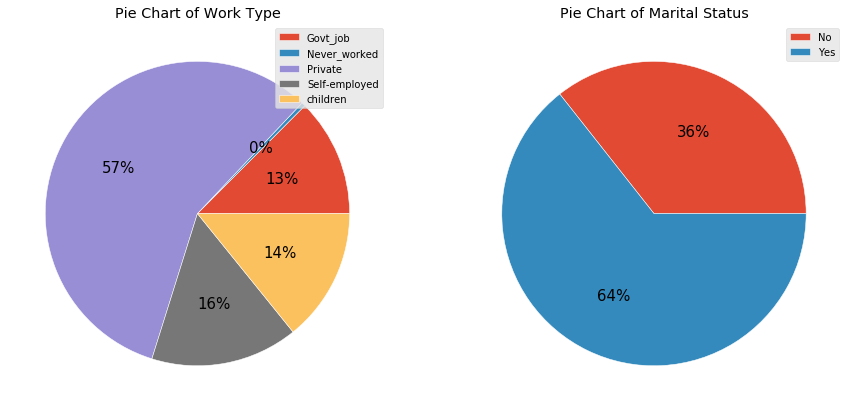

In [16]:
plot_pie_chart(df_grp_work_type, 'Work Type',
               df_grp_marital_status, 'Marital Status')

C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


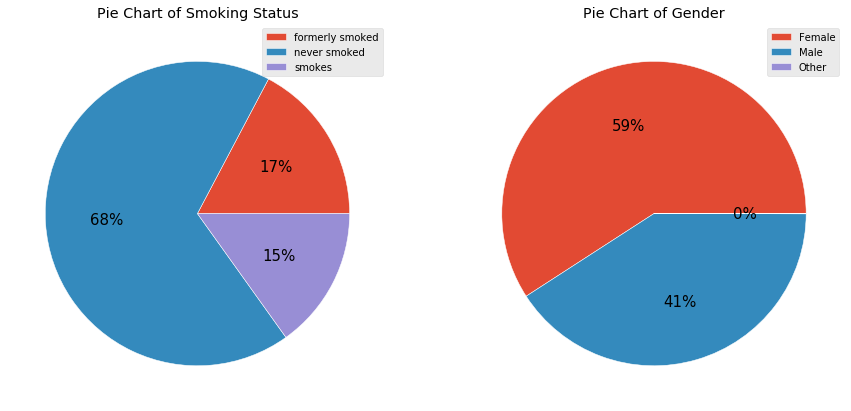

In [17]:
plot_pie_chart(df_grp_smoking_status, 'Smoking Status',
               df_grp_gender, 'Gender')

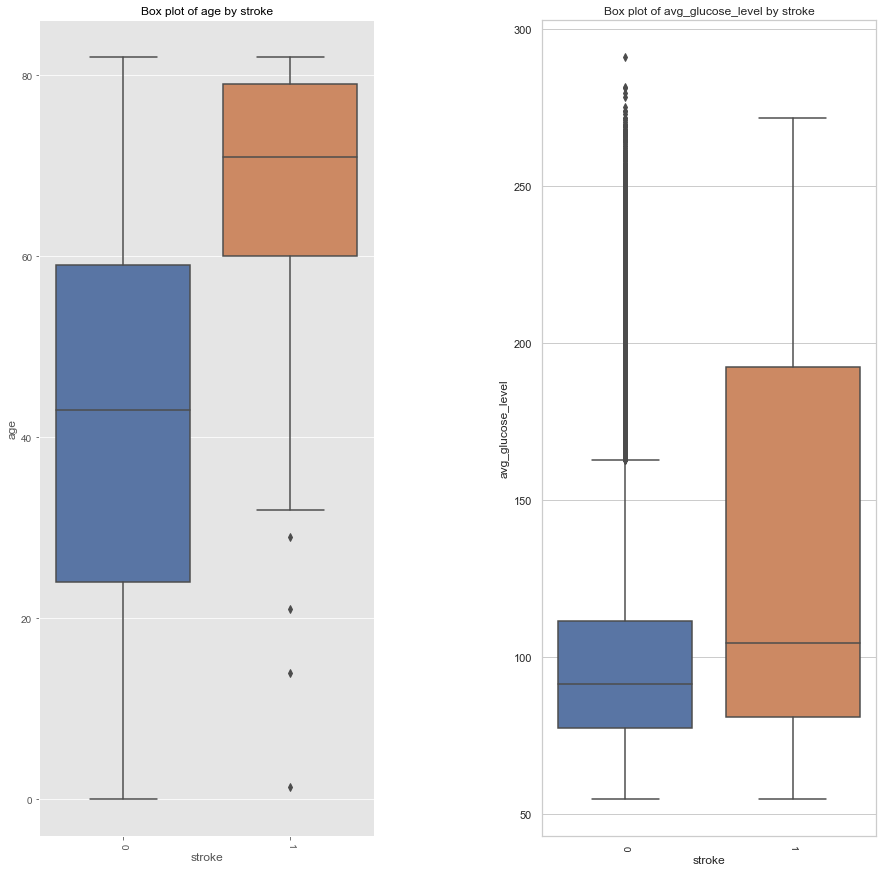

In [18]:
# ---7 visualize data: bi-variate ---
# plot a box-whisker:    
plot_box(df_eda, 'age', 'stroke',
        'avg_glucose_level', 'stroke')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43400 entries, 8373 to 38446
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null category
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null category
work_type            43400 non-null category
Residence_type       43400 non-null category
avg_glucose_level    43400 non-null float64
bmi                  43400 non-null float64
smoking_status       43400 non-null category
stroke               43400 non-null int64
dtypes: category(5), float64(3), int64(4)
memory usage: 2.9 MB


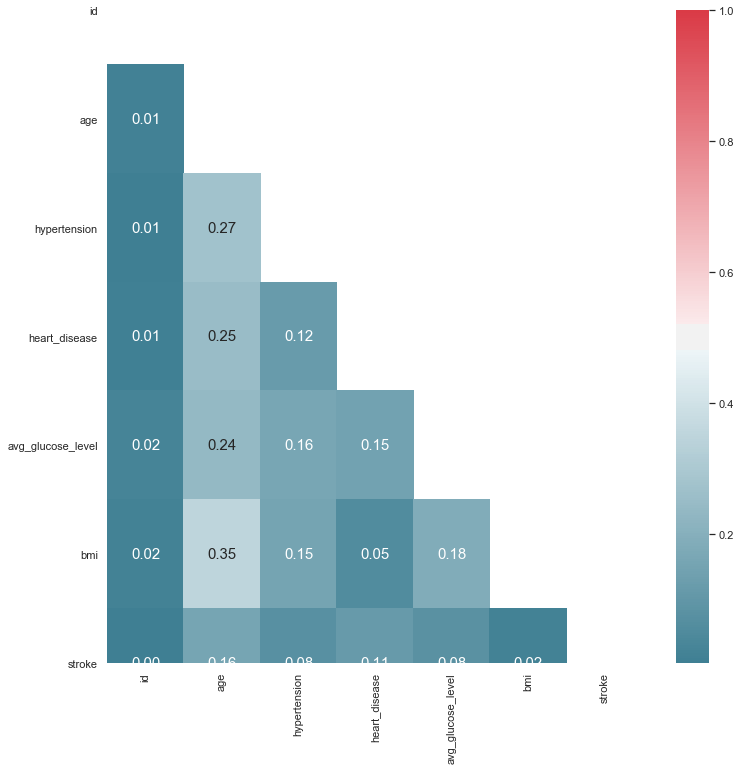

In [19]:
# create a dataframe:
df_eda_cm = df_eda.copy()

# check data type:
df_eda_cm.info()

# convert data type: object to category
convert_dt_to_cat(df_eda_cm)

# encode categorical variables using age:
for col in df_eda_cm.columns:
    if df_eda_cm[col].dtype.name == 'category':
        eda_encode_cat_var(df_eda_cm, col, 'age')

# Create a list of variables:
list_vars = list(df_eda_cm.columns)

# Delete a list of unwanted variables:
unwanted_list = {'ever_married', 'work_type', 
                 'Residence_type', 'smoking_status'}

list_vars = [item for item in list_vars if item not in unwanted_list]

# plot a correlation matrix:
plot_corr_matrix(df_eda_cm, list_vars)

In [20]:
# plot a cross-tabulation:
plot_crosstab(df_eda, 'heart_disease', 'stroke')

stroke,0,1
heart_disease,,
0,40732,606
1,1885,177


In [21]:
plot_crosstab(df_eda, 'hypertension', 'stroke')

stroke,0,1
hypertension,,
0,38756,583
1,3861,200


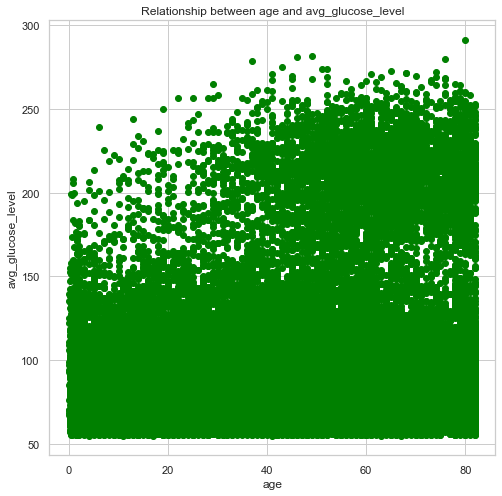

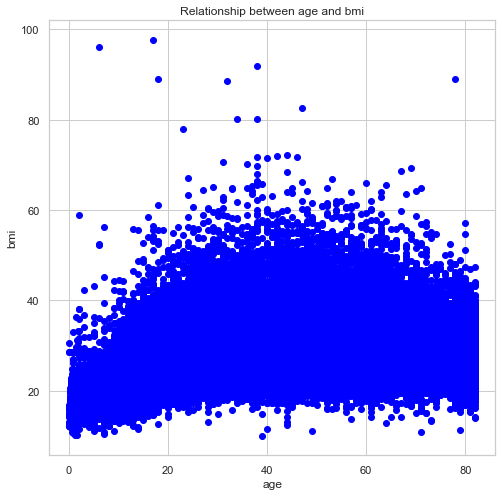

In [22]:
#---- Plot a scatter plot: w numerical variables ----#
plot_scatter(df_eda, 'age', 'avg_glucose_level', 'green')

plot_scatter(df_eda, 'age', 'bmi', 'blue')

0.2376268428055484


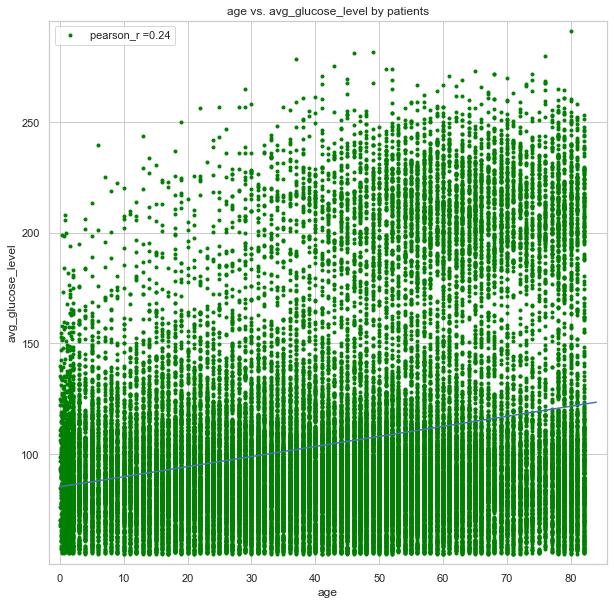

In [23]:
# Compute Pearson r for age and avg.glucose level:
r_age_glucose= compute_pearson_r(df_eda, 'age', 'avg_glucose_level')
print(r_age_glucose) 

# Plot a linear regression analysis:
plot_linear_reg(df_eda, 'age', 'avg_glucose_level',
                r_age_glucose, 'green', 'patients')
plt.show()

0.35223642748789097


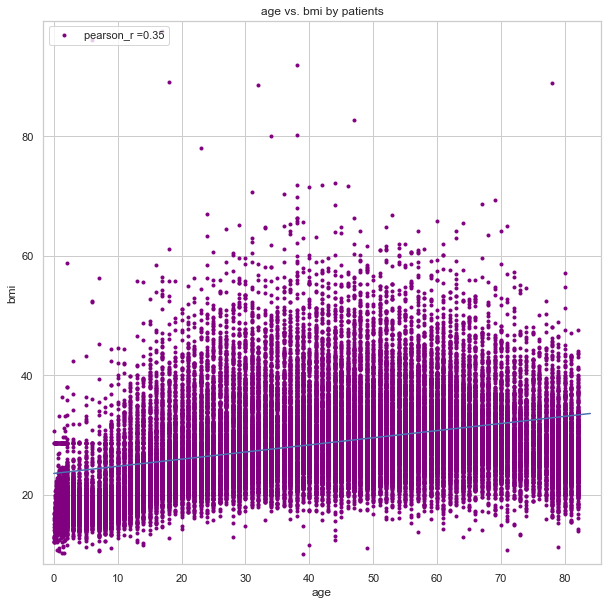

In [24]:
# Compute Pearson r for age and bmi:
r_age_bmi = compute_pearson_r(df_eda, 'age', 'bmi')
print(r_age_bmi) 

# Plot a linear regression analysis:
plot_linear_reg(df_eda, 'age', 'bmi',
                r_age_bmi, 'purple', 'patients')
plt.show()

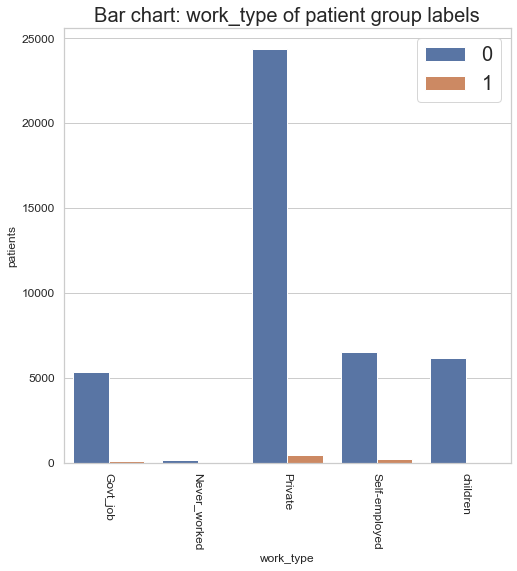

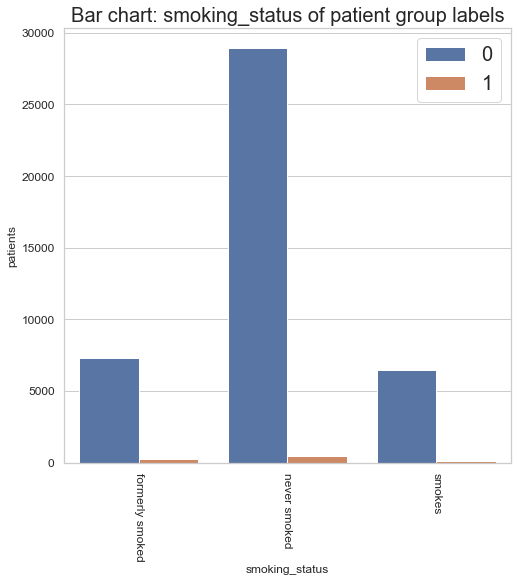

In [25]:
# plot a frequency chart:
plot_freq_chart('work_type', 'stroke', df_eda, None)

plot_freq_chart('smoking_status', 'stroke', df_eda, None)